In [37]:
!pip install fastai
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [40]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [43]:
# path = './poems'
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ls: cannot access 'path': No such file or directory


In [47]:
path="drive/MyDrive/poem/poems"
!ls drive/MyDrive/poem/poems

abc		   decastich	       octave
abecedarian	   didactic-poetry     ode
acrostic	   dirge	       ottava-rima
alexandrine	   divino-sonetto      oulipo
allegory	   dizain	       palindrome-or-mirror-poetry
anacreontic	   doggerel	       palinode
anagram		   double-dactyl       panegyric
anaphora	   dramatic-monologue  pantoum
arabian-sonnet	   echo-verse	       pastoral
ars-poetica	   eclogue	       pindaric-ode
aubade		   ekphrastic	       prose-poem
balassi-stanza	   elegy	       qasida
ballad		   epic		       quatern
ballade		   epigram	       quatrain
beymorlin-sonnet   epistle	       refrain
bio		   epistrophe	       renga
blank-verse	   epitaph	       rhyme-royal-or-rime-royale
blues-poem	   epithalamion        rictameter
blues-sonnet	   found-poem	       riddle
bop		   fourteener	       rispetto
bref-double	   free-verse	       rondeau
brisbane-sonnet    ghazal	       rondel-or-roundel
bucolic		   glosa	       sapphic
burlesque	   haiku	       senryu
burns-stanza	   heroic-couplet

In [48]:
poems = get_text_files(path, folders = ['carol','haiku'])
print("There are",len(poems),"poems in the dataset")

There are 198 poems in the dataset


In [60]:
ballads = get_text_files(path, folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [50]:
txt = poems[0].open().read(); #read the first file
print(txt)

haiku one:
in criss-crossing shadows
of the mountains, we admire
sunbathed summits
haiku two:
in criss crossing shadows
we admire sunbathed
summits
haiku three:
tottering ballet dancer
the butterfly flutters
round a bloom
haiku three:
dead widow's bamboo bell
each chime echoes
a memory of her
dead widow's bamboo bell
each chime numbs
the mind
dead widow's bamboo bell
each chime echoes
a lonely year/her lonely years
haiku four;
dead widow's bamboo bell
forelorn the chime
has become
tanka:
dugout river
a nude doll stares
right through me
i discover stephen king and
- shiver


## Prepare the data

In [72]:
ballads = L(o.open().read() for o in ballads[:6000]) # to make things easy we will gather all texts in one numpy array
ballads


(#100) ['A Ballad of Burdens\nThe burden of fair women. Vain delight,\nAnd love self-slain in some sweet shameful way,\nAnd sorrowful old age that comes by night\nAs a thief comes that has no heart by day,\nAnd change that finds fair cheeks and leaves them grey,\nAnd weariness that keeps awake for hire,\nAnd grief that says what pleasure used to say;\nThis is the end of every man\'s desire.\nThe burden of bought kisses. This is sore,\nA burden without fruit in childbearing;\nBetween the nightfall and the dawn threescore,\nThreescore between the dawn and evening.\nThe shuddering in thy lips, the shuddering\nIn thy sad eyelids tremulous like fire,\nMakes love seem shameful and a wretched thing.\nThis is the end of every man\'s desire.\nThe burden of sweet speeches. Nay, kneel down,\nCover thy head, and weep; for verily\nThese market-men that buy thy white and brown\nIn the last days shall take no thought for thee.\nIn the last days like earth thy face shall be,\nYea, like sea-marsh made 

In [73]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)
len(all_ballads)

100

In [74]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [75]:
splits = [range_of(70), range(100)] # use a 70/30 split

tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [77]:
show_at(tls.train, 0)

A Ballad of Burdens
The burden of fair women. Vain delight,
And love self-slain in some sweet shameful way,
And sorrowful old age that comes by night
As a thief comes that has no heart by day,
And change that finds fair cheeks and leaves them grey,
And weariness that keeps awake for hire,
And grief that says what pleasure used to say;
This is the end of every man's desire.
The burden of bought kisses. This is sore,
A burden without fruit in childbearing;
Between the nightfall and the dawn threescore,
Threescore between the dawn and evening.
The shuddering in thy lips, the shuddering
In thy sad eyelids tremulous like fire,
Makes love seem shameful and a wretched thing.
This is the end of every man's desire.
The burden of sweet speeches. Nay, kneel down,
Cover thy head, and weep; for verily
These market-men that buy thy white and brown
In the last days shall take no thought for thee.
In the last days like earth thy face shall be,
Yea, like sea-marsh made thick with brine and mire,
Sad wi

In [78]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 1024). Running this sequence through the model will result in indexing errors


In [79]:
dls.show_batch(max_n=2)

,text,text_
0,"DOWN harvest headlands the fairy host\nOf the poppy banners have flashed and fled,\nThe lilies have faded like ghost and ghost,\nThe ripe rose rots in the garden bed.\nThe grain is garnered, the blooms are shed,\nConvolvulus springs on the snowdrop’s bier,\nIn her stranded gold is the silver thread\nOf the first grey hair i’ the head o’ the year.\nLike an arrant knave from a bootless boast,\nThe fire-wind back to his North has sped\nTo harry the manes of a haunted coast\nOn a far sea-rim where the stars are dead.\nWistful the welkin with wordless dread,\nMournful the uplands, all ashen sere—\nSad for the snow on a beauteous head—\nFor the first grey hair i’ the head o’ the year.\nTime trysts with Death at the finger-post,\nWhere the broken issues of life are wed—\nIntone no dirges, fill up the toast\nTo the troops that trip it with silent tread,\nMerry we’ll make it tho’ skies be lead","harvest headlands the fairy host\nOf the poppy banners have flashed and fled,\nThe lilies have faded like ghost and ghost,\nThe ripe rose rots in the garden bed.\nThe grain is garnered, the blooms are shed,\nConvolvulus springs on the snowdrop’s bier,\nIn her stranded gold is the silver thread\nOf the first grey hair i’ the head o’ the year.\nLike an arrant knave from a bootless boast,\nThe fire-wind back to his North has sped\nTo harry the manes of a haunted coast\nOn a far sea-rim where the stars are dead.\nWistful the welkin with wordless dread,\nMournful the uplands, all ashen sere—\nSad for the snow on a beauteous head—\nFor the first grey hair i’ the head o’ the year.\nTime trysts with Death at the finger-post,\nWhere the broken issues of life are wed—\nIntone no dirges, fill up the toast\nTo the troops that trip it with silent tread,\nMerry we’ll make it tho’ skies be lead,"
1,"all of birds bellowed and fell,\nA cloud blew the rain from its throat;\nHe saw the storm smoke out to kill\nWith fuming bows and ram of ice,\nFire on starlight, rake Jesu's stream;\nAnd nothing shone on the water's face\nBut the oil and bubble of the moon,\nPlunging and piercing in his course\nThe lured fish under the foam\nWitnessed with a kiss.\nWhales in the wake like capes and Alps\nQuaked the sick sea and snouted deep,\nDeep the great bushed bait with raining lips\nSlipped the fins of those humpbacked tons\nAnd fled their love in a weaving dip.\nOh, Jericho was falling in their lungs!\nShe nipped and dived in the nick of love,\nSpun on a spout like a long-legged ball\nTill every beast blared down in a swerve\nTill every turtle crushed from his shell\nTill every bone in the rushing grave\nRose and crowed and fell!\nGood luck to the hand on the rod,\nThere is thunder under its thumbs;\nGold gut is a lightning","of birds bellowed and fell,\nA cloud blew the rain from its throat;\nHe saw the storm smoke out to kill\nWith fuming bows and ram of ice,\nFire on starlight, rake Jesu's stream;\nAnd nothing shone on the water's face\nBut the oil and bubble of the moon,\nPlunging and piercing in his course\nThe lured fish under the foam\nWitnessed with a kiss.\nWhales in the wake like capes and Alps\nQuaked the sick sea and snouted deep,\nDeep the great bushed bait with raining lips\nSlipped the fins of those humpbacked tons\nAnd fled their love in a weaving dip.\nOh, Jericho was falling in their lungs!\nShe nipped and dived in the nick of love,\nSpun on a spout like a long-legged ball\nTill every beast blared down in a swerve\nTill every turtle crushed from his shell\nTill every bone in the rushing grave\nRose and crowed and fell!\nGood luck to the hand on the rod,\nThere is thunder under its thumbs;\nGold gut is a lightning"


## Fine-tuning the model

In [80]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [81]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [82]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


(#2) [4.1803998947143555,65.39199829101562]

SuggestedLRs(valley=3.630780702224001e-05)

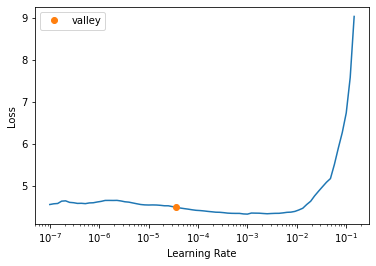

In [83]:
learn.lr_find()

In [84]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.327093,3.974171,53.206013,21:25


## Poem Generation

In [85]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
# inp.shape

In [86]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous.
But I am not afraid of him,
I am afraid that he will not see me
When he sees me, or when he hears me;
And I have no fear that I will never see him again."
"And what is the matter with you?"



In [89]:
prompt = "heartbreak"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
heartbreak.
"I'm glad to see you again," he said, "but I don't know what to do with you. I'm afraid I'll never be able to go home again."
He went on to say that he was afraid he'd never see his wife again, and


In [92]:
import pickle

In [94]:
filename = "model.sav"
pickle.dump(learn.model, open(filename, "wb"))

In [100]:
model_saved = pickle.load(open(filename, "rb"))
model_saved

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro